In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

# Resources

1. Timeseries Generator examples: https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

2. LR Finder and Restarts: https://www.jeremyjordan.me/nn-learning-rate/

### TS Generator
generator = TimeseriesGenerator(inputs, outputs, ...)
* length: The number of lag (previous) observations to use in the input portion of each sample (e.g. 3).
* batch_size: The number of samples to return on each iteration (e.g. 32)

#### fit_generator
*  It also takes a steps_per_epoch argument that defines the number of samples to use in each epoch. This can be set to the length of the TimeseriesGenerator instance to use all samples in the generator. if batchsize is 1, can be set to steps_per_epoch=len(generator)
* steps_per_epoch = data_set_size / batch_size

Similarly, the generator can be used to evaluate a fit model by calling the **evaluate_generator()** function, and using a fit model to make predictions on new data with the **predict_generator()** function.

A model fit with the data generator does not have to use the generator versions of the evaluate and predict functions. They can be used only if you wish to have the data generator prepare your data for the model.

### Multivariate Inputs and Dependent Series Example

For this first pass, we're basically assuming only 1 sample. For example, this could be information about one stock or patient: the in_seqs are variables about the stock/patient, the out_seq is the thing we'd like to predict about that stock/patient at the *NEXT* time point.

Next step here would be to join multiple samples together for learning.

In [3]:
# define dataset
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105])
out_seq = np.array([25, 45, 65, 85, 105, 125, 145, 165, 185, 205])

In [4]:
# reshape series from vector to proper array
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [5]:
# horizontally stack columns so that we have [[t1_var1, t1_var2], [t2_var1, t2_var2]]
dataset = np.hstack((in_seq1, in_seq2))

In [6]:
dataset

array([[ 10,  15],
       [ 20,  25],
       [ 30,  35],
       [ 40,  45],
       [ 50,  55],
       [ 60,  65],
       [ 70,  75],
       [ 80,  85],
       [ 90,  95],
       [100, 105]])

In [7]:
# define generator
n_priors = 1
generator = TimeseriesGenerator(dataset, out_seq, length=n_priors, batch_size=1)

In [8]:
# print each sample
# myd = [] #save data for each person, then stack(data_p1, data_p2)?
for i in range(len(generator)):
    x, y = generator[i]
    print('%s => %s' % (x, y))
    #myd.append(x)

[[[10. 15.]]] => [[45.]]
[[[20. 25.]]] => [[65.]]
[[[30. 35.]]] => [[85.]]
[[[40. 45.]]] => [[105.]]
[[[50. 55.]]] => [[125.]]
[[[60. 65.]]] => [[145.]]
[[[70. 75.]]] => [[165.]]
[[[80. 85.]]] => [[185.]]
[[[90. 95.]]] => [[205.]]


In [25]:
from keras import optimizers
n_features = dataset.shape[1]
optimizer = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_priors, n_features)))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')

In [18]:
# fit model
model.fit_generator(generator, steps_per_epoch=len(generator), epochs=500, verbose=0)

In [40]:
# make a one step prediction out of sample
x_input = np.array([[95], [105]]).reshape((1, n_priors, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[223.26486]]


In [ ]:
# try fit_evalulate and fit_predict

# LR Finder

#### Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 

In [19]:
from findLR import LRFinder

In [29]:
epoch_size = len(generator)
batch_size=1
lr_finder = LRFinder(min_lr=1e-5,
                    max_lr=1e-2,
                    steps_per_epoch=np.ceil(epoch_size/batch_size),
                    epochs=3)

In [30]:
#model.fit(X_train, Y_train, callbacks=[lr_finder])
model.fit_generator(generator, steps_per_epoch=len(generator), verbose=1,callbacks=[lr_finder] )

Epoch 1/1
9/9 [==============================] - 0s 6ms/step - loss: 12043290.4375


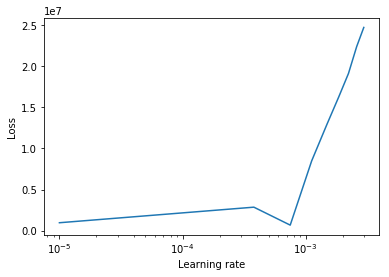

In [31]:
lr_finder.plot_loss()

In [32]:
diab = pd.read_csv('diabetes.csv')

In [37]:
diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [52]:
data = diab.values
x_diab = data[:,:-1]
y_diab = data[:,-1]
y_diab = y_diab.reshape(y_diab.shape[0],1)
y_diab[:5], x_diab.shape[1]

(array([[1.],
        [0.],
        [1.],
        [0.],
        [1.]]), 8)

In [118]:
model = Sequential()
model.add(Dense(12, input_shape=(x_diab.shape[1],), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [111]:
epoch_size = x_diab.shape[1]
batch_size=10
lr_finder = LRFinder(min_lr=1e-5,
                    max_lr=1e-2,
                    steps_per_epoch=np.ceil(epoch_size/batch_size),
                    epochs=3)

In [112]:
model.fit(x_diab, y_diab, callbacks=[lr_finder], validation_split = 0.2)

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 0s 219us/step - loss: 0.8916 - val_loss: 0.6786


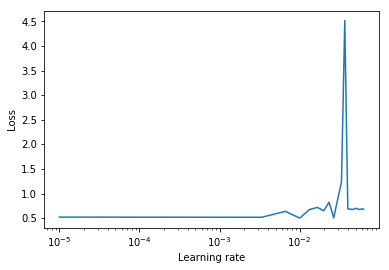

In [113]:
lr_finder.plot_loss()

In [89]:
(10e-3 + 10e-2)/2

0.055

In [119]:
lr = 0.055
optimizer = optimizer = optimizers.SGD(lr=10e-4, momentum=0.0, decay=0.0, nesterov=False)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

In [120]:
model.fit(x_diab, y_diab,epochs = 20, validation_split = 0.2,batch_size = batch_size)

Train on 614 samples, validate on 154 samples
Epoch 1/20
614/614 [==============================] - 1s 1ms/step - loss: 3.8187 - val_loss: 2.7890
Epoch 2/20
614/614 [==============================] - 0s 291us/step - loss: 3.2043 - val_loss: 2.7801
Epoch 3/20
614/614 [==============================] - 0s 281us/step - loss: 2.9816 - val_loss: 2.0885
Epoch 4/20
614/614 [==============================] - 0s 285us/step - loss: 1.8830 - val_loss: 0.7980
Epoch 5/20
614/614 [==============================] - 0s 290us/step - loss: 0.7785 - val_loss: 0.6834
Epoch 6/20
614/614 [==============================] - 0s 291us/step - loss: 0.7457 - val_loss: 0.6818
Epoch 7/20
614/614 [==============================] - 0s 288us/step - loss: 0.7409 - val_loss: 0.6803
Epoch 8/20
614/614 [==============================] - 0s 287us/step - loss: 0.7371 - val_loss: 0.6792
Epoch 9/20
614/614 [==============================] - 0s 290us/step - loss: 0.7335 - val_loss: 0.6784
Epoch 10/20
614/614 [=================

Something weird happens if lr_finder is used and then the model is recompiled and run. The model learns nothing. 